### Complete multimodal scan list

In [2]:
import pandas as pd

from tqdm import tqdm

##### MRI

In [3]:
df_mri = pd.read_csv("./Key_MRI_30Nov2025.csv")

In [4]:
# Filter for t1 3d acquisitons
df_mri = df_mri[    (df_mri["acquisition_type"] == "3D") & 
                    (df_mri["series_type"] == "T1w")]

print(len(df_mri))

19734


In [5]:
df_mri = df_mri[["image_id", "image_date","subject_id","magnetic_field_strength"]]

In [6]:
df_mri["modality"] = "MRI-T1-3D-3T"

In [7]:
df_mri.loc[ df_mri["magnetic_field_strength"] == 1.5, "modality"] = "MRI-T1-3D-1.5T"
df_mri = df_mri[ ["image_id", "image_date","subject_id", "modality"]]

In [8]:
df_mri

,image_id,image_date,subject_id,modality
0,28561,2006-11-02,002_S_0295,MRI-T1-3D-1.5T
1,28560,2006-11-02,002_S_0295,MRI-T1-3D-1.5T
3,55275,2007-05-25,002_S_0295,MRI-T1-3D-1.5T
4,55276,2007-05-25,002_S_0295,MRI-T1-3D-1.5T
6,114210,2008-07-23,002_S_0295,MRI-T1-3D-1.5T
...,...,...,...,...
90439,11490056,2025-11-13,027_S_6842,MRI-T1-3D-3T
90443,11491175,2025-11-17,021_S_4276,MRI-T1-3D-3T
90447,11491179,2025-11-18,033_S_10008,MRI-T1-3D-3T
90451,11491187,2025-11-18,033_S_10009,MRI-T1-3D-3T


##### PET

In [9]:
df_pet = pd.read_csv("./Key_PET_06Dec2025.csv")
df_pet = df_pet[ (df_pet["tau_pet"] == "Y") | 
                 (df_pet["amyloid_pet"] == "Y") | 
                 (df_pet["radiopharmaceutical"] == "18F-FDG")]
print(len(df_pet))

9533


In [10]:
df_pet["modality"] = "PET-FDG"
df_pet.loc[df_pet["tau_pet"] == "Y", "modality"] = "PET-tau"
df_pet.loc[df_pet["amyloid_pet"] == "Y", "modality"] = "PET-amyloid"

In [11]:
df_pet = df_pet[ ["image_id","image_date","subject_id","modality"]]

In [12]:
df_pet.groupby("modality").nunique()["image_id"]

modality
PET-FDG        2699
PET-amyloid    4417
PET-tau        2417
Name: image_id, dtype: int64

In [13]:
df_final = pd.concat([df_mri, df_pet])

In [14]:
df_final.to_csv("./dataset_multimodal.csv", index=False)

In [15]:
# Number of patients
df_final["subject_id"].unique().__len__()

3256

<Axes: ylabel='Frequency'>

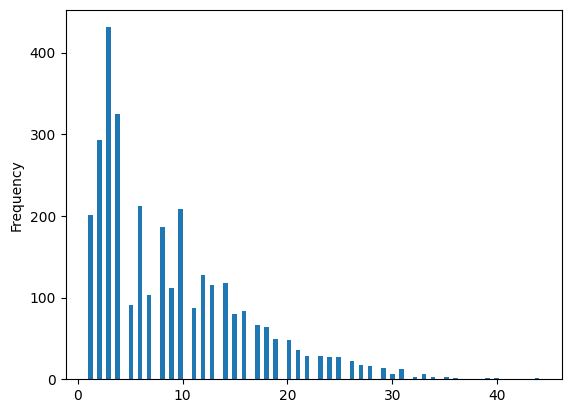

In [16]:
df_final.groupby("subject_id").nunique()["image_id"].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

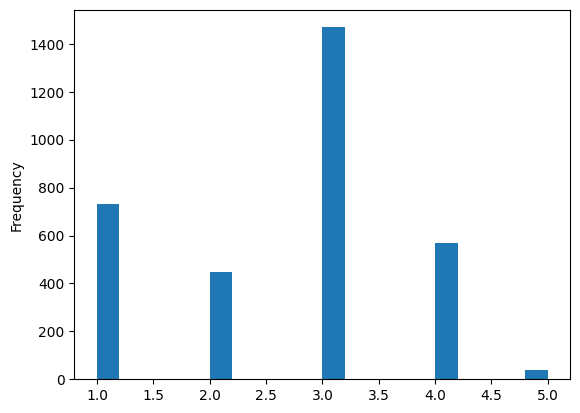

In [34]:
# modalities per patient statistics
df_final.groupby("subject_id").nunique()["modality"].plot.hist(bins=20)

Print image IDs conveniently for download

In [1]:
import pandas as pd

df = pd.read_csv("dataset_multimodal.csv")

In [38]:
ids = df["image_id"].astype(str).to_list()
ids1 = ids[:5000]
ids2 = ids[5000:10000]
ids3 = ids[10000:15000]
ids4 = ids[15000:20000]
ids5 = ids[20000:25000]
ids6 = ids[25000:]

In [37]:
print(len(ids))

29267


In [35]:
",".join(ids6)

'1594751,1596788,1596794,1596800,1596810,1596854,1596877,1600763,1600824,1600932,1600942,1601044,1614466,1614473,1600063,1600071,1600177,1601027,1601082,1592954,1593020,1593078,1593089,1593125,1593138,1599410,1599421,1599627,1600203,1600236,1600258,1600287,1600311,1600333,1593484,1593492,1601954,1602090,1595796,1595799,1595853,1595811,1595849,1595924,1595948,1610536,1610628,1596202,1596204,1630312,1600635,1600661,1600668,1600671,1600674,1600703,1600714,1634264,1602390,1602408,1602433,1602437,1602441,1602498,1602512,1614552,1595129,1595151,1595164,1595172,1598283,1598363,1598369,1597637,1597691,1594971,1594986,1597978,1598020,1598060,1598121,1598129,1598187,1614211,1614250,1592996,1593057,1593120,1598312,1598315,1598321,1598355,1598364,1598402,1614341,1614356,1601844,1601862,1602041,1602051,1602118,1602149,1597345,1597545,1602806,1602824,1602849,1594294,1594308,1594321,1594339,1594368,1594371,1594411,1594414,1610586,1610627,1602823,1602862,1600766,1600780,1600810,1600831,1600845,1600870

### Test faster method for diagnosis matching

In [17]:
df_diag = pd.read_csv("./DXSUM_13Aug2025.csv")
df_scan = pd.read_csv("./dataset_multimodal.csv")

# Ensure EXAMDATE and image_date columns are datetimes
df_scan["image_date"] = pd.to_datetime(df_scan["image_date"])
df_diag["EXAMDATE"] = pd.to_datetime(df_diag["EXAMDATE"])

In [ ]:
to_concat = []
tolerance = 180

# Ensure datetime dtype once (do outside loop in real code)
df_scan = df_scan.copy()
df_diag = df_diag.copy()
df_scan["image_date"] = pd.to_datetime(df_scan["image_date"])
df_diag["EXAMDATE"]  = pd.to_datetime(df_diag["EXAMDATE"])

for subj in tqdm(df_scan["subject_id"].unique()):

    # Get subject visits and scans
    subj_vis = df_diag[df_diag["PTID"] == subj].copy()
    subj_scans = df_scan[df_scan["subject_id"] == subj].copy()

    # Drop NaN values
    subj_vis = subj_vis.dropna(subset=["EXAMDATE"])
    subj_scans = subj_scans.dropna(subset=["image_date"])
    
    # Merge_asof requires sorting by the key
    subj_vis = subj_vis.sort_values("EXAMDATE")
    subj_scans = subj_scans.sort_values("image_date")

    # Match nearest withing tolerance
    nearest = pd.merge_asof(
        subj_scans,
        subj_vis[["EXAMDATE", "DIAGNOSIS"]],
        left_on="image_date",
        right_on="EXAMDATE",
        direction="nearest",
        tolerance=pd.Timedelta(days=tolerance),
    )

    # Get matched and append to list
    matched = nearest[nearest["DIAGNOSIS"].notna()].copy()
    matched = matched.rename(columns={"DIAGNOSIS": "diagnosis", "EXAMDATE":"exam_date"})
    matched = matched[["image_id", "image_date", "subject_id", "modality", "exam_date", "diagnosis"]]  
    
    to_concat.append(matched)

    # Matched ids
    matched_ids = set(matched["image_id"])

    # If all scans matched, continue
    if len(matched_ids) == len(subj_scans):
        continue

    # Remaining scans (no visit within tolerance)
    remaining = subj_scans[~subj_scans["image_id"].isin(matched_ids)].copy()
    remaining = remaining.sort_values("image_date")

    # Get closest visits before
    before = pd.merge_asof(
        remaining,
        subj_vis[["EXAMDATE", "DIAGNOSIS"]],
        left_on="image_date",
        right_on="EXAMDATE",
        direction="backward",   # visit on/before scan
        allow_exact_matches=True,
    ).rename(columns={"EXAMDATE": "EXAMDATE_before", "DIAGNOSIS": "DIAGNOSIS_before"})

    # Get closest visits after
    after = pd.merge_asof(
        remaining,
        subj_vis[["EXAMDATE", "DIAGNOSIS"]],
        left_on="image_date",
        right_on="EXAMDATE",
        direction="forward",    # visit on/after scan
        allow_exact_matches=True,
    ).rename(columns={"EXAMDATE": "EXAMDATE_after", "DIAGNOSIS": "DIAGNOSIS_after"})

    
    bracket = before.merge(
        after[["image_id", "EXAMDATE_after", "DIAGNOSIS_after"]],
        on="image_id",
        how="inner",
    )

    # need both sides, and diagnosis must agree
    bracket = bracket[
        bracket["DIAGNOSIS_before"].notna()
        & bracket["DIAGNOSIS_after"].notna()
        & (bracket["DIAGNOSIS_before"] == bracket["DIAGNOSIS_after"])
    ].copy()

    bracket["DIAGNOSIS"] = bracket["DIAGNOSIS_after"]
    
    # Keep only relevant columns and rename
    bracket = bracket[["image_id", "image_date", "subject_id", "modality", "DIAGNOSIS"]]
    
    bracket = bracket.rename(columns={"DIAGNOSIS":"diagnosis", "EXAMDATE":"exam_date"})
    
    to_concat.append(bracket)


  1%|          | 18/3256 [00:00<00:18, 171.54it/s]

100%|██████████| 3256/3256 [00:21<00:00, 153.72it/s]


In [20]:
final_df = pd.concat(to_concat, ignore_index=True, sort=False)
print(len(final_df))

28797


In [22]:
final_df.to_csv('dataset_multimodal_matched.csv', index=False)

Some stats

In [23]:
# Diagnosis distribution
final_df.groupby("diagnosis").nunique()["image_id"]

diagnosis
1.0    11072
2.0    12501
3.0     5224
Name: image_id, dtype: int64

<Axes: ylabel='Frequency'>

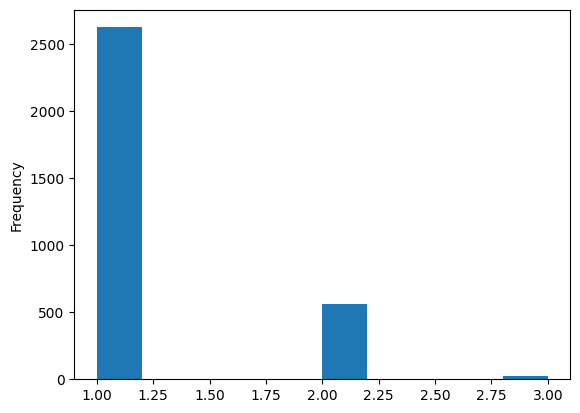

In [24]:
# Patient conversions: 1 -> no conversions, 2 -> 1 conversion, 3 -> 2 conversions 
final_df.groupby(["subject_id"]).nunique()["diagnosis"].plot.hist()

In [25]:
# Modality distribution
final_df.groupby("modality").nunique()["image_id"]

modality
MRI-T1-3D-1.5T     5404
MRI-T1-3D-3T      14079
PET-FDG            2684
PET-amyloid        4309
PET-tau            2321
Name: image_id, dtype: int64

<Axes: ylabel='Frequency'>

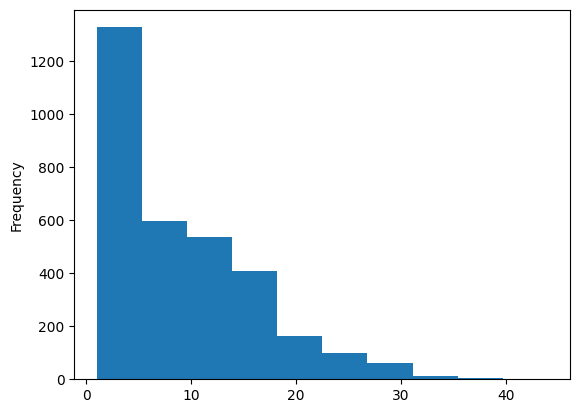

In [26]:
 #Distribution of number of scans per patient
final_df.groupby("subject_id").nunique()['image_id'].plot.hist()

<Axes: ylabel='Frequency'>

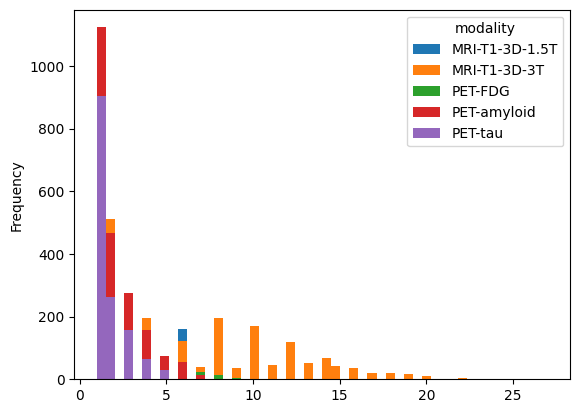

In [27]:
# Distributions of modalities (graphs are overlapped)
final_df.groupby(["subject_id", "modality"]).nunique()["image_id"].unstack("modality").plot.hist(bins=50)

### Multimodal samples creation

In [2]:
import pandas as pd

In [3]:
# Load dataset
df = pd.read_csv("./dataset_multimodal_matched.csv")

# Ensure image_date is of datetime type
df["image_date"] = pd.to_datetime(df["image_date"])

In [4]:
from tqdm import tqdm

from pysat.examples.rc2 import RC2
from pysat.formula import WCNF

tolerance = 180

# Helper functions
def check_valid(sample, tolerance):
    """
    Checks if scans in sample are within tolerance. 
    """
    
    # Extract scans dates
    dates = [ s[1] for s in sample if s is not None]
    
    # Check wheter timeframe is below tolerance
    return abs( max(dates) - min(dates)).days <= tolerance

def weight(sample):
    """
    Returns weight of sample for MaxSAT. 
    """
    
    # Weight = number of modalities
    return len([ scan for scan in sample if scan is not None])

def disjoint(s1, s2):
    """
    Returns whether sample 1 and sample 2 are disjoint
    """
    id1 = { e[0] for e in s1 if e is not None }
    id2 = { e[0] for e in s2 if e is not None }

    return id1.isdisjoint(id2)
        

def create_multimodal_samples(scans):
    """
    Creates disjoint multimodal samples, each for every
    scan of the minority modality. 

    Returns (samples, used_ids)
    """

    if scans.empty:
        return ([], [])

    # Get lowest count modality
    min_mode = scans.groupby("modality")["image_id"].nunique().idxmin()
    
    # Get other available modalities
    avail_modes = sorted(scans["modality"].unique())
    avail_modes.remove(min_mode)

    # Store candidate multimodal samples
    candidate_samples = []
    
    # Use lowest count modality as anchor modality
    for _, row in scans[scans["modality"] == min_mode].iterrows():
            
        # Get scans within tolerance 
        tol_scans = scans[(scans["modality"] != min_mode) 
                        & (abs(scans["image_date"] - row["image_date"]).dt.days <= tolerance )]
        
       
        # For each modality, grow possible samples under tolerance
        samples = [ (tuple(row[["image_id", "image_date"]]),) ]

        for mode in avail_modes:
                
            # Skip anchor modality
            if mode == min_mode:
                continue
            
            # Scans to choose from this modality (or choose none)
            options = [ e for e in tol_scans[ tol_scans["modality"] == mode][["image_id", "image_date"]].itertuples(name=None, index=False) ] + [None]
            
            # Grow samples with options from current modality  
            new_samples = []
            
            for s in samples:
                for o in options:
                    # Create new multimodal sample
                    new = s + (o,)
                    
                    # If under tolerance, add
                    if check_valid(new, tolerance):
                        new_samples.append(new)

            samples = new_samples
    
        # Add samples 
        candidate_samples += samples
        
    # Solve ILP problem to find best subset of disjoint multimodal samples

    if not candidate_samples:
        return ([], [])
    
    # Create SAT solver instance
    wcnf = WCNF()
        
    # Add soft clauses with weight
    for i, s in enumerate(candidate_samples):
        wcnf.append([i+1], weight=weight(s))
            
    # Add disjoint constraints
    for i in range(len(candidate_samples)):
        for j in range(i+1, len(candidate_samples)):
                    
            # If samples are not disjoint, add clause
            if not disjoint(candidate_samples[i], candidate_samples[j]):
                wcnf.append([-(i+1), -(j+1)])
                        
    # Solve
    solver = RC2(wcnf)
    model = solver.compute()

    # Get selected samples
    selected_samples = [ s for i,s in enumerate(candidate_samples) if (i+1) in model]

    all_modes = [min_mode] + avail_modes

    # return list of samples
    ret = []

    # And of the scan ids used in these samples
    used_ids = []

    # Convert to dicts for ease
    for s in selected_samples:

        # Update used ids
        for e in s:
            if e is not None:
                used_ids.append(e[0])

        # Convert sample to dict
        s = {all_modes[i]:s[i][0] for i in range(len(all_modes)) if s[i] is not None}
        
        ret.append(s)

    return (ret, used_ids)

#------------------------------------------------------------------------------------


# Entries for mmodal dataframe
entries = []

# All modalities
modalities = sorted(df["modality"].unique())

for group, indices in tqdm(df.groupby(["subject_id", "diagnosis"]).groups.items()):
    
    # Get scans of current group
    scans = df.loc[indices]
    
    samples = []

    for i in range(6):

        current_samples, used_ids = create_multimodal_samples(scans)

        # Append samples 
        samples += current_samples

        # Update scans 
        scans = scans[~scans["image_id"].isin(used_ids)]


    # Add multimodal samples to final dataframe entries
    for s in samples:

        s["diagnosis"] = group[1]
        s["subject_id"] = group[0]
        
        entries.append(s)

    # Add remaining scans as unimodal samples to final dataframe entries
    for _, row in scans.iterrows():

        s = {row["modality"]:row["image_id"]}
        s["diagnosis"] = group[1]
        s["subject_id"] = group[0]

        entries.append(s)
        

100%|██████████| 3826/3826 [00:35<00:00, 108.90it/s]


In [5]:
df_final = pd.DataFrame(entries)
df_final

,PET-FDG,MRI-T1-3D-3T,PET-amyloid,diagnosis,subject_id,MRI-T1-3D-1.5T,PET-tau
0,1592036.0,238627.0,1592037.0,1.0,002_S_0295,NaN,NaN
1,NaN,238628.0,NaN,1.0,002_S_0295,NaN,NaN
2,NaN,303066.0,NaN,1.0,002_S_0295,NaN,NaN
3,NaN,303067.0,NaN,1.0,002_S_0295,NaN,NaN
4,NaN,NaN,NaN,1.0,002_S_0295,28561.0,NaN
...,...,...,...,...,...,...,...
19487,NaN,1588331.0,1614614.0,1.0,941_S_7074,NaN,1623497.0
19488,NaN,10283169.0,10311819.0,1.0,941_S_7074,NaN,10314161.0
19489,NaN,1600180.0,NaN,2.0,941_S_7085,NaN,NaN
19490,NaN,1591321.0,NaN,1.0,941_S_7087,NaN,NaN


In [8]:
modes = (df_final[ ["PET-FDG","PET-amyloid","PET-tau","MRI-T1-3D-3T", "MRI-T1-3D-1.5T"]].notna()*1 )
modes.head()

,PET-FDG,PET-amyloid,PET-tau,MRI-T1-3D-3T,MRI-T1-3D-1.5T
0,1,1,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,0,1


In [25]:
len( modes[ (modes["PET-tau"] == 1) & (modes["MRI-T1-3D-3T"] == 1)])

2039

5 passes
```
1    13419
2     3145
3     2624
4      304
Name: count, dtype: int64
```

2 passes
```
1    14325
2     2698
3     2620
4      304
Name: count, dtype: int64
```

1 pass
```
1    17445
3     2160
2     1828
4      304
Name: count, dtype: int64
```

ModuleNotFoundError: No module named 'adni_mri_classification'